In [30]:
import pycocotools.coco as coco
import json
import os
from PIL import Image

import numpy as np
import scipy.io
mat = scipy.io.loadmat("/media/allen/mass/shanshanzhang-citypersons-dec0e5b2f30a/annotations/anno_train.mat")
# data = np.array(data)

In [31]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'anno_train_aligned'])

In [32]:
dataset = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}
dataset['categories'].append({
    'id': 1,
    'name': "person",
    'supercategory': "people",
    'keypoints': [],
    'skeleton': []
})

src = '/media/allen/mass/leftImg8bit_trainvaltest/leftImg8bit/train'
dst = '/media/allen/mass/DB/cityperson/train2017'
# city_name; im_name; bbs
sub_index = 0
idx = 0
for anns in mat['anno_train_aligned'][0]:
    city, im_name, bbs = anns[0][0]
    if not os.path.exists(os.path.join(dst, str(city[0]))):
        os.mkdir(os.path.join(dst, str(city[0])))
    img_name = str(city[0]) + "/" + str(im_name[0])
    
    l_bbs = []
    r_bbs = []
    for bb in bbs:        
        class_label, x1, y1, w, h, instance_id, x1_vis, y1_vis, w_vis, h_vis = bb 
        if class_label == 0 or y1 > 790:
            continue
        if y1 + h > 790:
            h = 790 - y1
            
        if x1 < 1024:
            if x1 + w > 1024:
                l_bbs.append([x1, y1, 1024 - x1, h])
                r_bbs.append([0, y1, x1 + w - 1024, h])
            else:
                l_bbs.append([x1, y1, w, h])
        else:
            r_bbs.append([x1 - 1024, y1, w, h])  
            
    fname = os.path.join(src, img_name)
    img = Image.open(fname)
    np_img = np.array(img)
    l_img = np_img[:790,:1024,:]
    r_img = np_img[:790,1024:,:]
    img_name, ext = os.path.splitext(img_name)
    
    if len(l_bbs) > 0:
        l_img_name = f"{img_name}_left{ext}"
        Image.fromarray(l_img).save(os.path.join(dst, l_img_name))

        idx += 1
        dataset['images'].append({
            'coco_url': '',
            'date_captured': '',
            'file_name': l_img_name,
            'flickr_url': '',
            'id': idx,
            'license': 0,
            'width': 1024,
            'height': 790
        })
        
        for bb in l_bbs:
            sub_index += 1
            x1, y1, w, h = bb
            dataset['annotations'].append({
                'area': int(w*h),
                'bbox': [int(x1),int(y1),int(w),int(h)],
                'category_id': 1,
                'id': sub_index,
                'image_id': idx,
                'iscrowd': 0,
                'segmentation': [],
            })
            
    if len(r_bbs) > 0:
        r_img_name = f"{img_name}_right{ext}"
        Image.fromarray(r_img).save(os.path.join(dst, r_img_name))

        idx += 1
        dataset['images'].append({
            'coco_url': '',
            'date_captured': '',
            'file_name': r_img_name,
            'flickr_url': '',
            'id': idx,
            'license': 0,
            'width': 1024,
            'height': 790
        }) 
        for bb in r_bbs:
            sub_index += 1
            x1, y1, w, h = bb
            dataset['annotations'].append({
                'area': int(w*h),
                'bbox': [int(x1),int(y1),int(w),int(h)],
                'category_id': 1,
                'id': sub_index,
                'image_id': idx,
                'iscrowd': 0,
                'segmentation': [],
            })
#     break

/home/allen/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in short_scalars
/home/allen/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in short_scalars
/home/allen/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in ushort_scalars
/home/allen/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in ushort_scalars


In [6]:
import cv2

In [15]:
for bb in l_bbs:
    x1, y1, w, h = bb
    cv2.rectangle(l_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,255,255), 2)

In [33]:
with open('/media/allen/mass/DB/cityperson/original/instances_train2017.json', 'w') as f:
    json.dump(dataset, f)

In [19]:
co = coco.COCO('/media/allen/mass/DB/cityperson/original/instances_val2017.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [27]:
image_ids = co.getImgIds()
img_id = image_ids[150]
idxs = co.getAnnIds(imgIds=[img_id])
fname = co.loadImgs(ids=[img_id])[0]['file_name']

In [28]:
img = Image.open(os.path.join(dst, fname))
anns = co.loadAnns(idxs)

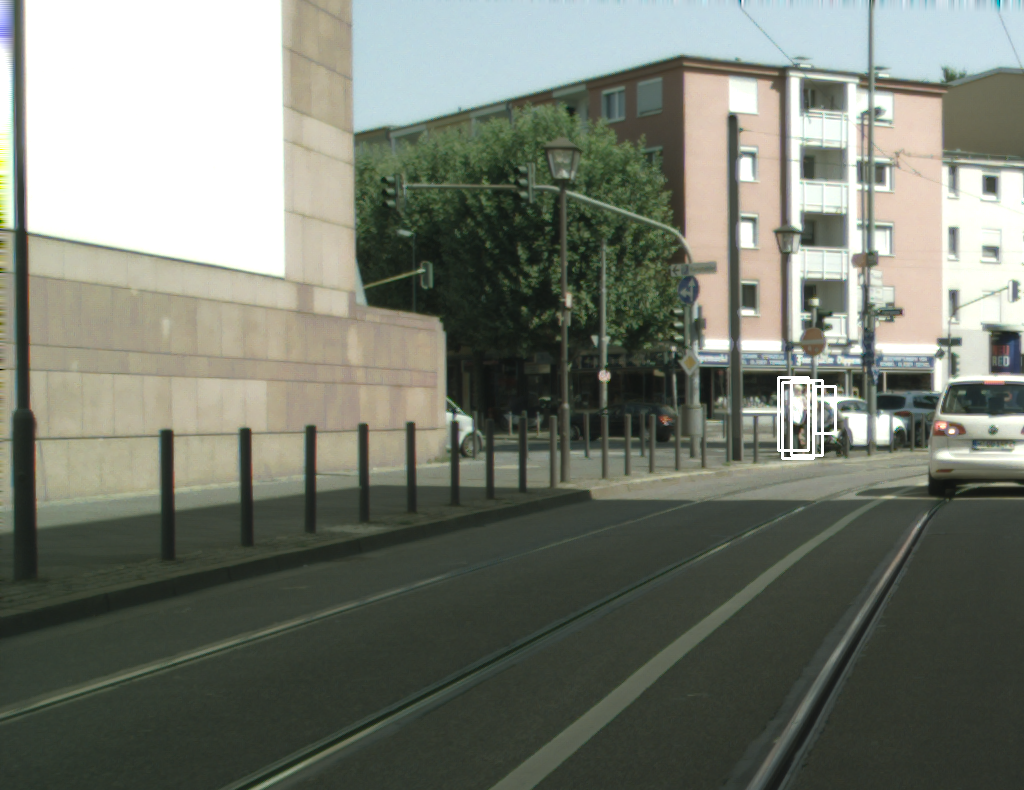

In [29]:
np_img = np.array(img)
for ann in anns:
    x1, y1, w, h = ann['bbox']
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,255,255), 2)
Image.fromarray(np_img)